In [1]:
import sys
sys.path.append("../")

from torch import nn
from data_utils import load_mnist, load_usps
from models import DomainAdaptationNetwork

import torch
from torch.nn import functional as F
import numpy as np
from train import train_domain_adaptation
from utils import test_network, plot_target_cross_domain_swapping, plot_tsne

In [2]:
torch.manual_seed(123)
import numpy as np
np.random.seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_space_dim, conv_feat_size, nb_channels=3):
        super(Decoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.conv_feat_size = conv_feat_size

        self.deco_dense = nn.Sequential(
            nn.Linear(in_features=latent_space_dim, out_features=1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features=np.prod(self.conv_feat_size)),
            nn.ReLU(True),
        )

        self.deco_fetures = nn.Sequential(
            nn.Conv2d(in_channels=self.conv_feat_size[0], out_channels=75, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=75, out_channels=50, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=50, out_channels=1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, z_share, z_spe):
        z = torch.cat([z_share, z_spe], 1)
        feat_encode = self.deco_dense(z)
        feat_encode = feat_encode.view(-1, *self.conv_feat_size)
        y = self.deco_fetures(feat_encode)

        return y


class Encoder(nn.Module):
    def __init__(self, latent_space_dim, img_size, nb_channels=3):
        super(Encoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.nb_channels = nb_channels

        self.conv_feat = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=50, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=50, out_channels=75, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.BatchNorm2d(75),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=75, out_channels=100, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(100),
        )

        self.conv_feat_size = self.conv_feat(torch.zeros(1, *img_size)).shape[1:]
        self.dense_feature_size = np.prod(self.conv_feat_size)

        self.dense_feat = nn.Sequential(
            nn.Linear(in_features=self.dense_feature_size, out_features=1024),
            nn.ReLU(True), )

        self.share_feat = nn.Sequential(
            nn.Linear(in_features=1024, out_features=latent_space_dim),
            nn.ReLU(True),
        )

        self.source_feat = nn.Sequential(
            nn.Linear(in_features=1024, out_features=latent_space_dim),
            nn.ReLU(True),
        )

        self.target_feat = nn.Sequential(
            nn.Linear(in_features=1024, out_features=latent_space_dim),
            nn.ReLU(True),
        )

    def forward(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_share = self.share_feat(feat)
        z_source = self.source_feat(feat)
        z_target = self.target_feat(feat)
        return z_share, z_source, z_target

    def forward_share(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_share = self.share_feat(feat)
        return z_share

    def forward_source(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_source = self.source_feat(feat)
        return z_source

    def forward_target(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_target = self.target_feat(feat)
        return z_target


In [4]:
learning_rate = 5e-4

source_train_loader, source_test_loader =  load_usps(img_size=32, rotation=20, split=1, batch_size=64, shuffle=True, num_workers=2)
target_train_loader, target_test_loader = load_mnist(img_size=32, rotation=20, batch_size=64, shuffle=True, num_workers=2)

encoder = Encoder(latent_space_dim=150, img_size=(1,32,32), nb_channels=1)

conv_feat_size = encoder.conv_feat_size
decoder_source = Decoder(latent_space_dim=300, conv_feat_size=conv_feat_size, nb_channels=1)
decoder_target = Decoder(latent_space_dim=300, conv_feat_size=conv_feat_size, nb_channels=1)

classifier = nn.Sequential(nn.Dropout2d(0.3),
                         nn.Linear(in_features=150, out_features=64),
                         nn.ReLU(0),
                         nn.Dropout2d(0.2),
                         nn.Linear(in_features=64, out_features=10),
                         nn.LogSoftmax())

model = DomainAdaptationNetwork(encoder, decoder_source, decoder_target, classifier).cuda()

optimizer = torch.optim.Adam([
    {'params': model.encoder.parameters()},
    {'params': model.decoder_source.parameters()},
    {'params': model.decoder_target.parameters()},
    {'params': model.classifier.parameters()},
    {'params': model.spe_predictor.parameters()},
    {'params': model.share_predictor.parameters()}], lr=learning_rate, weight_decay=0.001)

epochs = 50
betas = np.linspace(0, 5, epochs)

train_domain_adaptation(model, optimizer, source_train_loader, target_train_loader,
                                            epochs=50, betas=betas, gamma=0.5, delta=0.5)

  0%|          | 0/50 [00:00<?, ?it/s]/home/david/anaconda3/envs/domain_adaptation/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
epoch:0 current target accuracy:40.12%:   2%|▏         | 1/50 [00:09<07:33,  9.25s/it]

epoch [1/50], loss:1.7702
accuracy source: 86.61%
accuracy target: 40.09%


epoch:1 current target accuracy:58.29%:   4%|▍         | 2/50 [00:18<07:21,  9.19s/it]

epoch [2/50], loss:1.1859
accuracy source: 97.08%
accuracy target: 58.24%


epoch:2 current target accuracy:59.68%:   6%|▌         | 3/50 [00:27<07:10,  9.17s/it]

epoch [3/50], loss:1.0101
accuracy source: 98.49%
accuracy target: 59.64%


epoch:3 current target accuracy:63.84%:   8%|▊         | 4/50 [00:36<07:01,  9.15s/it]

epoch [4/50], loss:0.9535
accuracy source: 98.7%
accuracy target: 63.79%


epoch:4 current target accuracy:65.1%:  10%|█         | 5/50 [00:45<06:52,  9.16s/it] 

epoch [5/50], loss:0.9241
accuracy source: 98.94%
accuracy target: 65.05%


epoch:5 current target accuracy:67.3%:  12%|█▏        | 6/50 [00:54<06:43,  9.17s/it] 

epoch [6/50], loss:0.9299
accuracy source: 98.9%
accuracy target: 67.24%


epoch:6 current target accuracy:70.23%:  14%|█▍        | 7/50 [01:04<06:36,  9.22s/it]

epoch [7/50], loss:0.8800
accuracy source: 99.12%
accuracy target: 70.18%


epoch:7 current target accuracy:75.03%:  16%|█▌        | 8/50 [01:13<06:30,  9.29s/it]

epoch [8/50], loss:0.8501
accuracy source: 99.36%
accuracy target: 74.97%


epoch:8 current target accuracy:74.46%:  18%|█▊        | 9/50 [01:22<06:20,  9.27s/it]

epoch [9/50], loss:0.8277
accuracy source: 99.22%
accuracy target: 74.4%


epoch:9 current target accuracy:75.53%:  20%|██        | 10/50 [01:32<06:16,  9.41s/it]

epoch [10/50], loss:0.8051
accuracy source: 99.31%
accuracy target: 75.47%


epoch:10 current target accuracy:77.09%:  22%|██▏       | 11/50 [01:41<06:03,  9.33s/it]

epoch [11/50], loss:0.8087
accuracy source: 99.4%
accuracy target: 77.03%


epoch:11 current target accuracy:77.86%:  24%|██▍       | 12/50 [01:51<05:53,  9.32s/it]

epoch [12/50], loss:0.7943
accuracy source: 99.34%
accuracy target: 77.8%


epoch:12 current target accuracy:81.89%:  26%|██▌       | 13/50 [02:00<05:48,  9.42s/it]

epoch [13/50], loss:0.7828
accuracy source: 99.36%
accuracy target: 81.83%


epoch:13 current target accuracy:86.53%:  28%|██▊       | 14/50 [02:10<05:40,  9.45s/it]

epoch [14/50], loss:0.7849
accuracy source: 99.4%
accuracy target: 86.46%


epoch:14 current target accuracy:87.04%:  30%|███       | 15/50 [02:19<05:32,  9.50s/it]

epoch [15/50], loss:0.7437
accuracy source: 99.59%
accuracy target: 86.97%


epoch:15 current target accuracy:86.17%:  32%|███▏      | 16/50 [02:29<05:20,  9.42s/it]

epoch [16/50], loss:0.7380
accuracy source: 99.49%
accuracy target: 86.1%


epoch:16 current target accuracy:90.18%:  34%|███▍      | 17/50 [02:38<05:09,  9.37s/it]

epoch [17/50], loss:0.7357
accuracy source: 99.56%
accuracy target: 90.1%


epoch:17 current target accuracy:89.51%:  36%|███▌      | 18/50 [02:48<05:04,  9.51s/it]

epoch [18/50], loss:0.7657
accuracy source: 99.29%
accuracy target: 89.43%


epoch:18 current target accuracy:89.68%:  38%|███▊      | 19/50 [02:57<04:55,  9.52s/it]

epoch [19/50], loss:0.7585
accuracy source: 99.38%
accuracy target: 89.61%


epoch:19 current target accuracy:90.34%:  40%|████      | 20/50 [03:07<04:44,  9.48s/it]

epoch [20/50], loss:0.7114
accuracy source: 99.62%
accuracy target: 90.27%


epoch:20 current target accuracy:91.81%:  42%|████▏     | 21/50 [03:16<04:33,  9.42s/it]

epoch [21/50], loss:0.7185
accuracy source: 99.48%
accuracy target: 91.74%


epoch:21 current target accuracy:90.75%:  44%|████▍     | 22/50 [03:26<04:27,  9.54s/it]

epoch [22/50], loss:0.7111
accuracy source: 99.66%
accuracy target: 90.68%


epoch:22 current target accuracy:90.51%:  46%|████▌     | 23/50 [03:35<04:18,  9.56s/it]

epoch [23/50], loss:0.6881
accuracy source: 99.73%
accuracy target: 90.43%


epoch:23 current target accuracy:91.37%:  48%|████▊     | 24/50 [03:45<04:09,  9.61s/it]

epoch [24/50], loss:0.7132
accuracy source: 99.52%
accuracy target: 91.3%


epoch:24 current target accuracy:90.34%:  50%|█████     | 25/50 [03:55<04:01,  9.66s/it]

epoch [25/50], loss:0.7041
accuracy source: 99.47%
accuracy target: 90.27%


epoch:25 current target accuracy:91.08%:  52%|█████▏    | 26/50 [04:04<03:49,  9.58s/it]

epoch [26/50], loss:0.7039
accuracy source: 99.53%
accuracy target: 91.01%


epoch:26 current target accuracy:91.88%:  54%|█████▍    | 27/50 [04:14<03:38,  9.49s/it]

epoch [27/50], loss:0.6984
accuracy source: 99.52%
accuracy target: 91.8%


epoch:27 current target accuracy:93.39%:  56%|█████▌    | 28/50 [04:23<03:31,  9.61s/it]

epoch [28/50], loss:0.6794
accuracy source: 99.63%
accuracy target: 93.31%


epoch:28 current target accuracy:93.69%:  58%|█████▊    | 29/50 [04:33<03:23,  9.70s/it]

epoch [29/50], loss:0.6743
accuracy source: 99.75%
accuracy target: 93.61%


epoch:29 current target accuracy:93.07%:  60%|██████    | 30/50 [04:43<03:11,  9.56s/it]

epoch [30/50], loss:0.6735
accuracy source: 99.74%
accuracy target: 93.0%


epoch:30 current target accuracy:93.25%:  62%|██████▏   | 31/50 [04:52<03:01,  9.56s/it]

epoch [31/50], loss:0.6782
accuracy source: 99.67%
accuracy target: 93.17%


epoch:31 current target accuracy:93.18%:  64%|██████▍   | 32/50 [05:01<02:50,  9.49s/it]

epoch [32/50], loss:0.6799
accuracy source: 99.68%
accuracy target: 93.11%


epoch:32 current target accuracy:93.31%:  66%|██████▌   | 33/50 [05:11<02:41,  9.49s/it]

epoch [33/50], loss:0.6907
accuracy source: 99.51%
accuracy target: 93.23%


epoch:33 current target accuracy:93.51%:  68%|██████▊   | 34/50 [05:21<02:32,  9.54s/it]

epoch [34/50], loss:0.6625
accuracy source: 99.7%
accuracy target: 93.43%


epoch:34 current target accuracy:93.68%:  70%|███████   | 35/50 [05:30<02:21,  9.43s/it]

epoch [35/50], loss:0.6566
accuracy source: 99.64%
accuracy target: 93.6%


epoch:35 current target accuracy:93.76%:  72%|███████▏  | 36/50 [05:39<02:12,  9.48s/it]

epoch [36/50], loss:0.6473
accuracy source: 99.77%
accuracy target: 93.68%


epoch:36 current target accuracy:94.68%:  74%|███████▍  | 37/50 [05:49<02:03,  9.52s/it]

epoch [37/50], loss:0.6372
accuracy source: 99.78%
accuracy target: 94.6%


epoch:37 current target accuracy:95.39%:  76%|███████▌  | 38/50 [05:59<01:54,  9.57s/it]

epoch [38/50], loss:0.6300
accuracy source: 99.82%
accuracy target: 95.31%


epoch:38 current target accuracy:95.12%:  78%|███████▊  | 39/50 [06:08<01:45,  9.58s/it]

epoch [39/50], loss:0.6576
accuracy source: 99.79%
accuracy target: 95.04%


epoch:39 current target accuracy:95.93%:  80%|████████  | 40/50 [06:18<01:35,  9.55s/it]

epoch [40/50], loss:0.6373
accuracy source: 99.75%
accuracy target: 95.85%


epoch:40 current target accuracy:95.03%:  82%|████████▏ | 41/50 [06:27<01:25,  9.49s/it]

epoch [41/50], loss:0.6508
accuracy source: 99.75%
accuracy target: 94.96%


epoch:41 current target accuracy:94.33%:  84%|████████▍ | 42/50 [06:37<01:16,  9.58s/it]

epoch [42/50], loss:0.6532
accuracy source: 99.7%
accuracy target: 94.26%


epoch:42 current target accuracy:94.46%:  86%|████████▌ | 43/50 [06:47<01:07,  9.62s/it]

epoch [43/50], loss:0.6537
accuracy source: 99.79%
accuracy target: 94.38%


epoch:43 current target accuracy:95.08%:  88%|████████▊ | 44/50 [06:56<00:57,  9.64s/it]

epoch [44/50], loss:0.6855
accuracy source: 99.6%
accuracy target: 95.0%


epoch:44 current target accuracy:95.01%:  90%|█████████ | 45/50 [07:06<00:47,  9.59s/it]

epoch [45/50], loss:0.6809
accuracy source: 99.48%
accuracy target: 94.93%


epoch:45 current target accuracy:94.71%:  92%|█████████▏| 46/50 [07:15<00:37,  9.47s/it]

epoch [46/50], loss:0.6448
accuracy source: 99.75%
accuracy target: 94.63%


epoch:46 current target accuracy:94.13%:  94%|█████████▍| 47/50 [07:24<00:28,  9.38s/it]

epoch [47/50], loss:0.6641
accuracy source: 99.68%
accuracy target: 94.05%


epoch:47 current target accuracy:94.43%:  96%|█████████▌| 48/50 [07:34<00:18,  9.45s/it]

epoch [48/50], loss:0.6600
accuracy source: 99.63%
accuracy target: 94.35%


epoch:48 current target accuracy:94.62%:  98%|█████████▊| 49/50 [07:43<00:09,  9.38s/it]

epoch [49/50], loss:0.6391
accuracy source: 99.78%
accuracy target: 94.54%


epoch:49 current target accuracy:94.46%: 100%|██████████| 50/50 [07:52<00:00,  9.46s/it]

epoch [50/50], loss:0.6349
accuracy source: 99.81%
accuracy target: 94.38%


In [5]:
_, target_test_loader = load_mnist(img_size=32, rotation=0, batch_size=64, shuffle=True, num_workers=2)
model.eval()
test_network(model, target_test_loader)  

0.9499

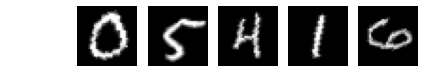

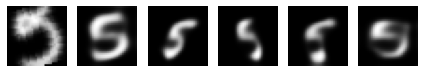

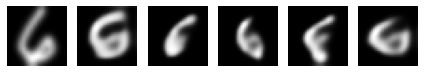

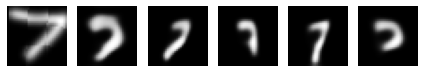

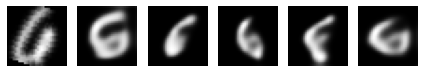

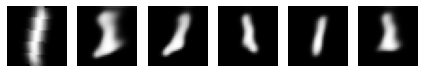

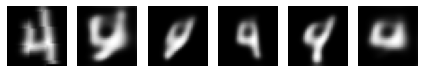

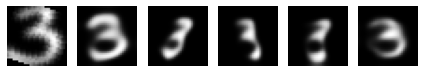

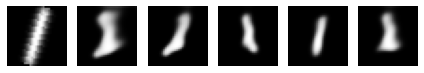

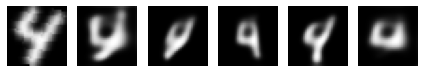

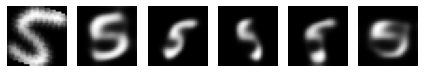

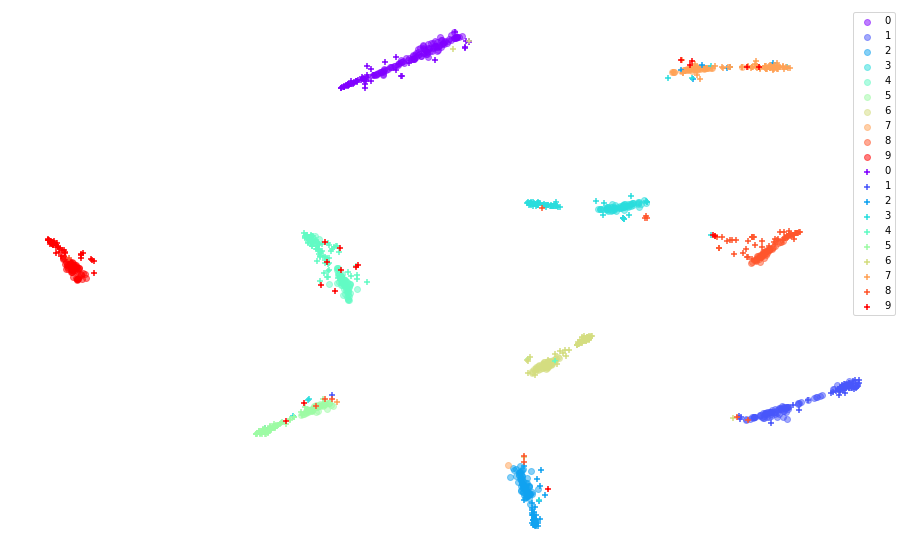

In [7]:
plot_target_cross_domain_swapping(model, source_train_loader, target_train_loader)
plot_tsne(model, source_train_loader, target_train_loader, batch_size=64, feature_size=150)